
Preparing category: PR Sharings
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230727\20230727_195927_pr_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230803\20230803_093947_pr_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230810\20230810_123110_pr_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230817\20230817_125147_pr_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230824\20230824_100450_pr_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230831\20230831_060603_pr_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230907\20230907_091631_pr_sharings.json
	Reading File: c:\Projects\software-engineering-project/src/raw_datasets\snapshot_20230914\20230914

<Figure size 1200x800 with 0 Axes>

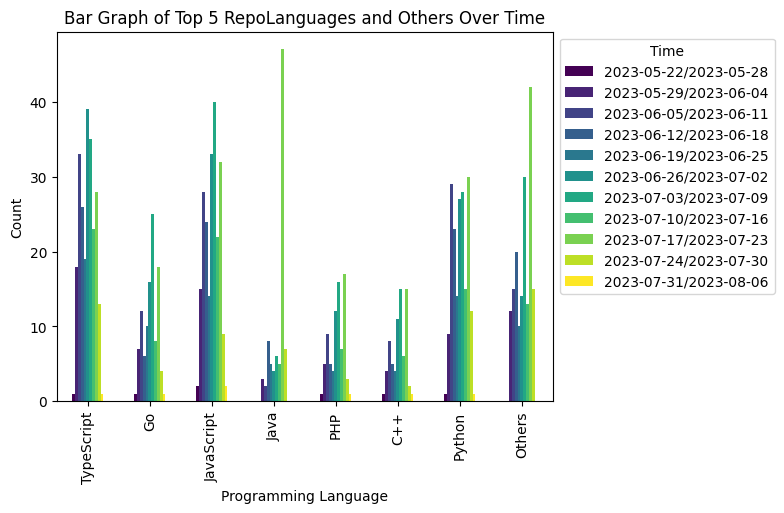

In [118]:
# Research question 2.

# Which programming languages do developers ask ChatGPT for
# help with, and how does this pattern change over time?

import os
import json
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
import seaborn as sns

CURRENT_DIRECTORY = "c:\\Projects\\software-engineering-project"
RAW_DATASETS_FILE_PATTERN = "/src/raw_datasets/*/*_"
DATASET_CATEGORIES = [
    # "Commit Sharings",
    "PR Sharings",
    # "Issue Sharings",
    # "Discussion Sharings",
]
OUTPUT_FOLDER_PATH = "/src/filtered_datasets/rq2/"


def read_datasets(filepath):
    print(f"\tReading File: {filepath}")
    with open(filepath) as file_content:
        json_data = json.load(file_content)
        df = pd.json_normalize(json_data, record_path="Sources")
    return df[["RepoLanguage", "ChatgptSharing"]]


def process_data(category_dfs):
    print(f"\n\tProcessing category data...")
    df = pd.concat(category_dfs)
    chatgpt_sharing = pd.json_normalize(df["ChatgptSharing"].map(lambda x: x[0]))
    conversation_date = pd.to_datetime(chatgpt_sharing["DateOfConversation"], errors="coerce").dt.strftime("%m-%d-%y")
    processed_df = df.drop("ChatgptSharing", axis=1).join(conversation_date)

    return processed_df[(processed_df.RepoLanguage.notnull()) & (processed_df.DateOfConversation.notnull())]


def write_processed_df(df, file):
    df.to_json(f"{CURRENT_DIRECTORY}{OUTPUT_FOLDER_PATH}{file.lower().replace(' ', '_')}.json", orient="records")
    df.to_csv(f"{CURRENT_DIRECTORY}{OUTPUT_FOLDER_PATH}{file.lower().replace(' ', '_')}.csv", index=False)
    print(f"\tProcessed data exported.")

def prepare_datasets():
    datasets = {}
    for file in DATASET_CATEGORIES:
        print(f"\nPreparing category: {file}")
        filepaths = glob(f"{CURRENT_DIRECTORY}{RAW_DATASETS_FILE_PATTERN}{file.lower().replace(' ','_')}.json")
        category_dfs = [read_datasets(filepath) for filepath in filepaths]            
        processed_df = process_data(category_dfs)

        datasets[file] = processed_df

        del category_dfs
        del processed_df

    return datasets


def plot_graphs(datasets):
    df = datasets["PR Sharings"]
    # grouped_df = df.groupby(["DateOfConversation", "RepoLanguage"])['RepoLanguage'].count().reset_index(name='Count')
    # pivot_df = grouped_df.pivot(index='DateOfConversation', columns='RepoLanguage', values='Count').fillna(0)

    # display(pivot_df)

    # Plot the line graph
    # ax = pivot_df.plot(kind='line', figsize=(10, 6), marker='o')
    # ax.set_xlabel('Month and Year')
    # ax.set_ylabel('Count')
    # ax.set_title('Count of RepoLanguage Over Months and Years')
    # # plt.legend(title='RepoLanguage', bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.show()

    df['DateOfConversation'] = pd.to_datetime(df['DateOfConversation'], format='%m-%d-%y')

    # Extract the month and year from the date
    df['MonthYear'] = df['DateOfConversation'].dt.to_period('W')

    # Sort unique months
    unique_months = sorted(df['MonthYear'].unique())

    # Define the number of top languages to include
    top_languages_count = 5  # Change to 5 for top 5 languages

    # Create a list to store data for each month
    stacked_data = []

    # Find the top 5 languages for each month and include them in all months
    top_languages_all_months = set()
    for month in unique_months:
        
        # Filter data for the current month
        month_data = df[df['MonthYear'] == month]
        
        # Get the top N programming languages and sort alphabetically
        top_languages = month_data['RepoLanguage'].value_counts().nlargest(top_languages_count).index
        top_languages_all_months.update(top_languages)

    # Iterate over unique months
    for month in unique_months:
        
        # Filter data for the current month
        month_data = df[df['MonthYear'] == month]
        
        # Get the top 5 programming languages and sort alphabetically
        top_languages = month_data['RepoLanguage'].value_counts().nlargest(top_languages_count).index
        language_counts = month_data['RepoLanguage'].value_counts().reindex(top_languages_all_months, fill_value=0)
        
        # Identify all languages not in the top 5 and group them into "Others"
        other_languages = month_data[~month_data['RepoLanguage'].isin(top_languages_all_months)]['RepoLanguage'].unique()
        language_counts['Others'] = month_data[month_data['RepoLanguage'].isin(other_languages)]['RepoLanguage'].count()
        
        # Store data for the current month
        stacked_data.append(language_counts)

    # Combine the data for all months into a DataFrame
    stacked_df = pd.concat(stacked_data, axis=1, keys=unique_months)

    # Plot vertical bar graph with grouped bars for each time period
    plt.figure(figsize=(12, 8))
    stacked_df.plot(kind='bar', colormap='viridis')
    plt.title(f'Bar Graph of Top {top_languages_count} RepoLanguages and Others Over Time')
    plt.xlabel('Programming Language')
    plt.ylabel('Count')
    plt.legend(title='Time', bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()


def main():
    datasets = prepare_datasets()
    plot_graphs(datasets)

main()

